# Notebook generating plots for NeurIPS paper

### Imports

In [10]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import nistats
import scipy
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nilearn.regions import RegionExtractor
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

In [11]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name
import reporting
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Defining variables

In [3]:
language = 'english'

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

Fetch a masker fitted on all subjects data and the following characterisctics:
- detrend: true
- dtype: null
- high_pass: null
- low_pass: null
- mask_strategy: background
- memory_level: 0
- n_jobs: 1
- smoothing_fwhm: null # try with 6 next time
- standardize: true
- t_r: null
- verbose: 0

In [5]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [6]:
masker = reporting.fetch_masker(MASKER_PATH, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

In [7]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'
x_labels = labels[1:]

## Group level analysis

In [16]:
model_names = [
    'glove_300_standardize_centering_{}',
    'glove_300_norm_np.inf_centering_scaling_axis_0_{}',
    'glove_300_norm_-np.inf_centering_scaling_axis_0_{}',
    'glove_300_norm_np.inf_centering_{}',
    'glove_300_norm_-np.inf_centering_{}',
    'glove_300_norm_5_centering_scaling_axis_1_{}',
    'glove_300_norm_4_centering_scaling_axis_1_{}',
    'glove_300_norm_3_centering_scaling_axis_1_{}',
    'glove_300_norm_2_centering_scaling_axis_0_{}',
    'glove_300_norm_-2_centering_scaling_axis_0_{}',
    'glove_300_norm_2_centering_{}',
    'glove_300_norm_-2_centering_{}',
    'glove_300_norm_1_centering_scaling_axis_0_{}',
    'glove_300_norm_-1_centering_scaling_axis_0_{}',
    'glove_300_norm_1_centering_{}',
    'glove_300_norm_-1_centering_{}',
    'glove_300_norm_0_centering_scaling_axis_0_{}',
    'glove_300_norm_0_centering_{}',
]

In [11]:
model_names = [
    'roberta-base_pre-15_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-9_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-3_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'gpt2_pre-0_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-0_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-2_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-25_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_old_scaled_{}_all-hidden-layers_pca_300',
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_{}_all-hidden-layers_pca_300', 
    'bert-base-cased_old_{}_all-hidden-layers_pca_300',
    'BF_rms_{}',
    'BF_log_frequency_{}',
    'BF_wordrate_{}',
    'BF_content_words_{}',
    'BF_function_words_{}',
    'BF_word_position_{}'
]

Loading data:

In [17]:
data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)

  4%|▍         | 2/51 [00:00<00:04, 11.76it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 10.27it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.78it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  6.77it/s]

sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:08,  5.20it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  6.54it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:04,  7.33it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  8.32it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  6.73it/s]

sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:06,  4.98it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:03<00:05,  5.50it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  5.91it/s]

sub-081 - 1 - 1
sub-082 - 1

 47%|████▋     | 24/51 [00:03<00:04,  5.59it/s]

 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  6.40it/s]

sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:04<00:04,  5.39it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  6.85it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.53it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:05<00:01,  8.15it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:05<00:01,  8.43it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:00, 11.74it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00, 13.24it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00, 14.63it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.74it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 18.23it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:01, 21.50it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 43%|████▎     | 22/51 [00:00<00:01, 22.13it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:00, 24.44it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:00, 21.31it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 86%|████████▋ | 44/51 [00:01<00:00, 28.68it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:02, 15.40it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.63it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 10.68it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.60it/s]

sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:06,  6.06it/s]

sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:05,  6.30it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.82it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  9.12it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 12.05it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 13.89it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 12.08it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:00, 14.50it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 18.85it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 37%|███▋      | 19/51 [00:00<00:00, 85.79it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 42.67it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 35.70it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 69%|██████▊   | 35/51 [00:00<00:00, 28.59it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 84%|████████▍ | 43/51 [00:01<00:00, 31.20it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 10%|▉         | 5/51 [00:00<00:01, 45.45it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 21.62it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:01, 21.06it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 39%|███▉      | 20/51 [00:00<00:01, 25.63it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:00, 30.89it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 82%|████████▏ | 42/51 [00:01<00:00, 39.20it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:00, 149.36it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:00<00:00, 74.61it/s] 

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:00<00:00, 32.03it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 82%|████████▏ | 42/51 [00:00<00:00, 43.41it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.49it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.89it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 12.28it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.12it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 15.85it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 14.99it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 14.76it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.63it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  8.97it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  9.06it/s]

sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:02,  7.59it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  7.97it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.93it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 13.74it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.22it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.24it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.07it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 12.19it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 18.36it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 18.43it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 69%|██████▊   | 35/51 [00:01<00:00, 22.45it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:01<00:00, 24.57it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 26.01it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.16it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04,  9.55it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.84it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.92it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 14.09it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 14.37it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 17.65it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 26.71it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:02<00:00, 28.61it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 11.42it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 11.92it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.93it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.09it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03,  8.56it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:03, 10.19it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  9.50it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.77it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.83it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 11.44it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 11.47it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 12.54it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.93it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 39%|███▉      | 20/51 [00:00<00:00, 179.76it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 94%|█████████▍| 48/51 [00:00<00:00, 134.25it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 25.76it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:01, 34.52it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 57%|█████▋    | 29/51 [00:00<00:00, 41.67it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 71%|███████   | 36/51 [00:00<00:00, 39.83it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 96%|█████████▌| 49/51 [00:01<00:00, 47.06it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.61it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.39it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.32it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  8.83it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 12.51it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:01, 16.93it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:01, 18.42it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 20.92it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:01<00:00, 23.80it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 25.45it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:02<00:00, 21.81it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:03, 13.99it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 16.73it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:01, 21.88it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 45%|████▌     | 23/51 [00:00<00:01, 22.81it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:00, 27.77it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:01<00:00, 19.43it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:01<00:00, 18.60it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:01<00:00, 17.57it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 11.54it/s]

sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00,  7.91it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00,  7.56it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 10.73it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 19.19it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 18.80it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 19.28it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:01, 18.77it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 23.86it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 61%|██████    | 31/51 [00:01<00:00, 28.31it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:01<00:00, 30.20it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 84%|████████▍ | 43/51 [00:01<00:00, 31.43it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:00, 42.16it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 33%|███▎      | 17/51 [00:00<00:00, 35.28it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 51%|█████     | 26/51 [00:00<00:00, 36.70it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:01, 23.51it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 45%|████▌     | 23/51 [00:00<00:00, 34.08it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:00<00:00, 28.53it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:00<00:00, 25.07it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 75%|███████▍  | 38/51 [00:01<00:00, 21.09it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:01<00:00, 19.59it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:01<00:00, 19.19it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:00, 52.07it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 47%|████▋     | 24/51 [00:00<00:00, 56.49it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


100%|██████████| 51/51 [00:00<00:00, 110.02it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


Checking if we have all the data:

In [15]:
reporting.check_data(data_full, 51)

Computing group level maps: (already computed)

In [13]:
models_tmp = [
    'roberta-base_pre-15_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-9_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-3_{}_all-hidden-layers_pca_300',
]
data_full_tmp = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in models_tmp }

In [18]:
reporting.compute_t_test_for_model_comparison(
                                        data_full_tmp, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

#####  glove_300_standardize_centering_R2  #####
#####  glove_300_standardize_centering_Pearson_coeff  #####
#####  glove_300_norm_npinf_centering_scaling_axis_0_R2  #####
#####  glove_300_norm_npinf_centering_scaling_axis_0_Pearson_coeff  #####
#####  glove_300_norm_-npinf_centering_scaling_axis_0_R2  #####
#####  glove_300_norm_-npinf_centering_scaling_axis_0_Pearson_coeff  #####
#####  glove_300_norm_npinf_centering_R2  #####
#####  glove_300_norm_npinf_centering_Pearson_coeff  #####
#####  glove_300_norm_-npinf_centering_R2  #####
#####  glove_300_norm_-npinf_centering_Pearson_coeff  #####
#####  glove_300_norm_5_centering_scaling_axis_1_R2  #####
#####  glove_300_norm_5_centering_scaling_axis_1_Pearson_coeff  #####
#####  glove_300_norm_4_centering_scaling_axis_1_R2  #####
#####  glove_300_norm_4_centering_scaling_axis_1_Pearson_coeff  #####
#####  glove_300_norm_3_centering_scaling_axis_1_R2  #####
#####  glove_300_norm_3_centering_scaling_axis_1_Pearson_coeff  #####
#####  glove

#### Surface plots of group level analysis

In [15]:
paths_group_level = {}
for model_name in model_names:
    name = model_name.replace('_{}', '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_group_level[name] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

In [16]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}

In [16]:
def plot_img_surf(surf_img, saving_path, plot_name, inflated=False, compute_surf=True, vmax=0.027, **kwargs):
    fsaverage = datasets.fetch_surf_fsaverage()
    if compute_surf:
        surf_img = vol_to_surf(surf_img, fsaverage[kwargs['surf_mesh']])
    if inflated:
        kwargs['surf_mesh'] = 'infl_left' if 'left' in kwargs['surf_mesh_type'] else 'infl_right' 
    disp = plotting.plot_surf_stat_map(
                        surf_mesh=fsaverage[kwargs['surf_mesh']], 
                        stat_map=surf_img,
                        hemi=kwargs['hemi'], 
                        view=kwargs['view'],
                        bg_map=fsaverage[kwargs['bg_map']], 
                        bg_on_data=kwargs['bg_on_data'],
                        darkness=kwargs['darkness'],
                        vmax=vmax
    )
    if saving_path:
        disp.savefig(saving_path + plot_name + '_{}_{}_{}.png'.format(kwargs['surf_mesh_type'], kwargs['hemi'], kwargs['view']))
    else:
        plotting.show()

########## bert-base-cased_pre-0_1_post-0_all-hidden-layers_pca_300 ##########


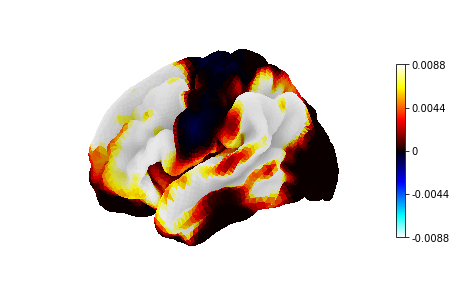

########## bert-base-cased_pre-1_1_post-0_all-hidden-layers_pca_300 ##########


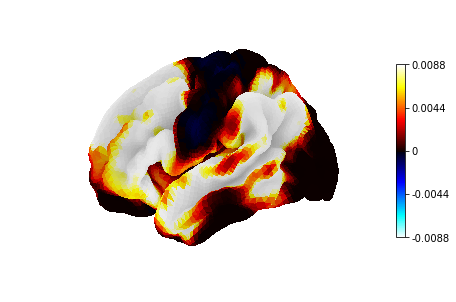

########## bert-base-cased_pre-2_1_post-0_all-hidden-layers_pca_300 ##########


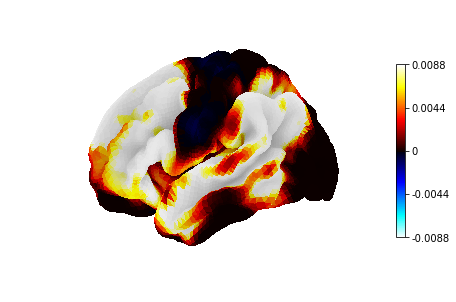

########## bert-base-cased_pre-5_1_post-0_all-hidden-layers_pca_300 ##########


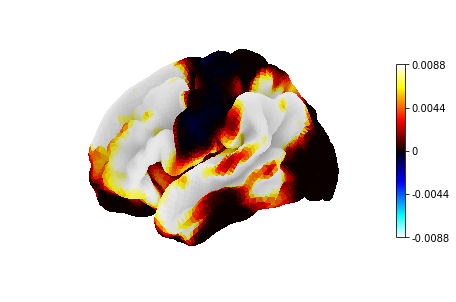

########## bert-base-cased_pre-10_1_post-0_all-hidden-layers_pca_300 ##########


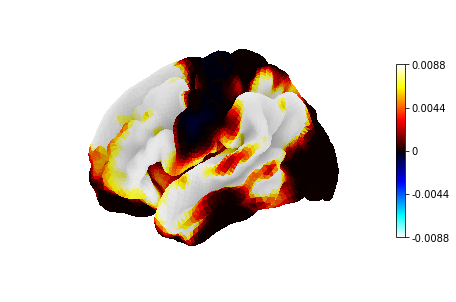

########## bert-base-cased_pre-15_1_post-0_all-hidden-layers_pca_300 ##########


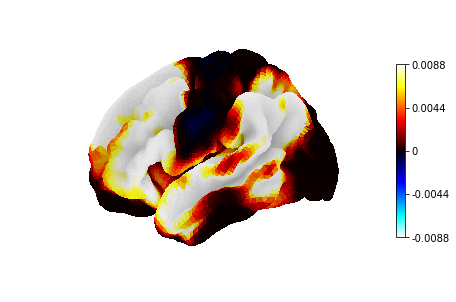

########## bert-base-cased_pre-20_1_post-0_all-hidden-layers_pca_300 ##########


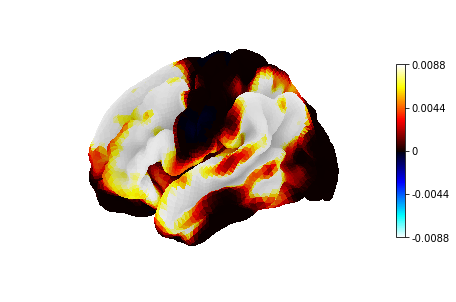

########## bert-base-cased_pre-25_1_post-0_all-hidden-layers_pca_300 ##########


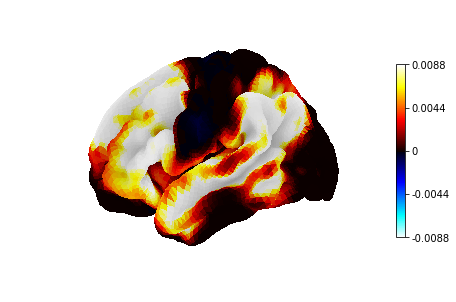

########## bert-base-cased_old_scaled_all-hidden-layers_pca_300 ##########


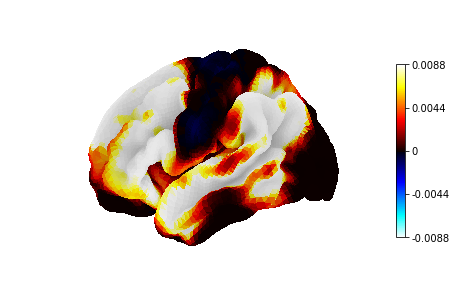

########## glove_300 ##########


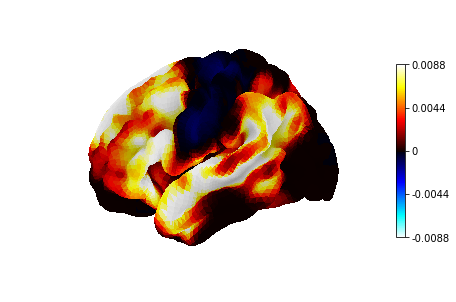

########## LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers ##########


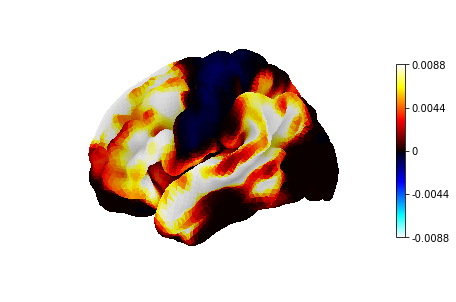

########## gpt2_scaled_all-hidden-layers_pca_300 ##########


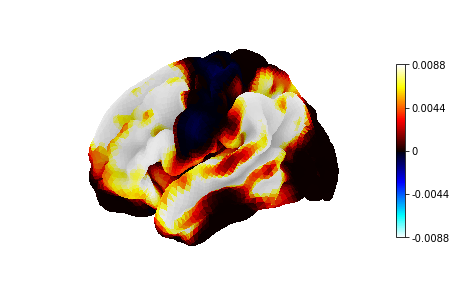

########## bert-base-cased_scaled_all-hidden-layers_pca_300 ##########


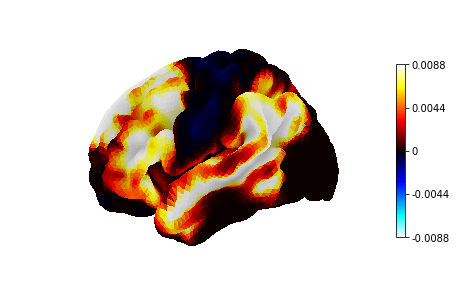

########## bert-base-cased_all-hidden-layers_pca_300 ##########


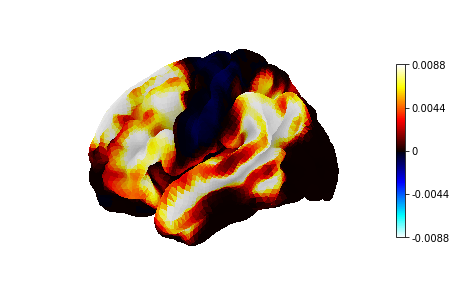

########## bert-base-cased_old_all-hidden-layers_pca_300 ##########


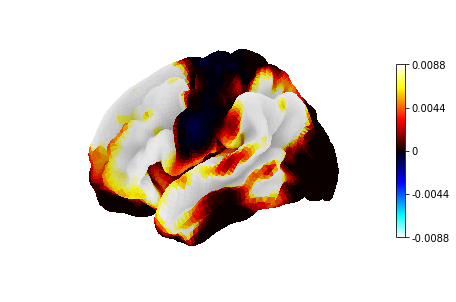

########## BF_rms ##########


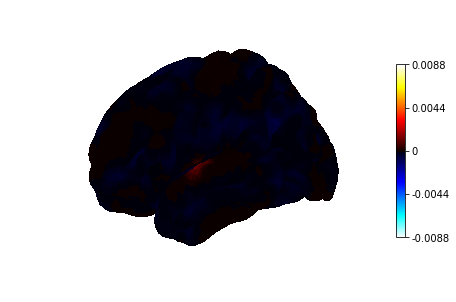

########## BF_log_frequency ##########


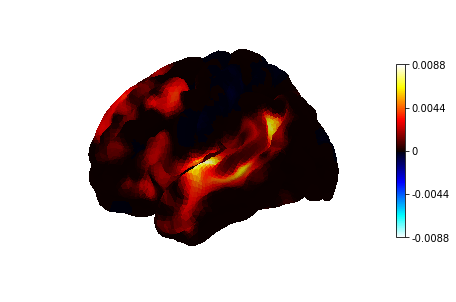

########## BF_wordrate ##########


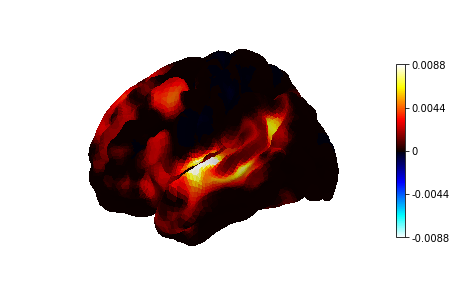

########## BF_content_words ##########


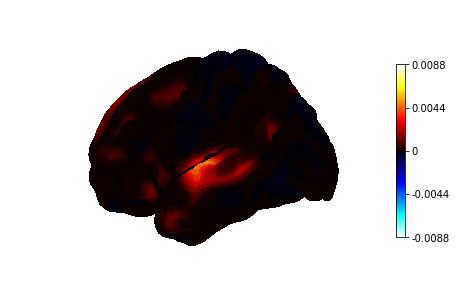

########## BF_function_words ##########


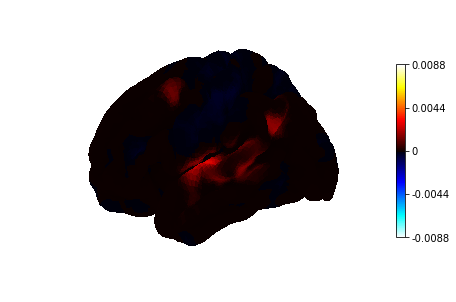

########## BF_word_position ##########


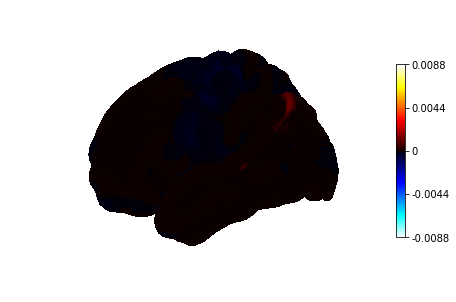

In [48]:
for index_model, model_name in enumerate(model_names):
    name = model_name.replace('_{}', '')
    print("#"*10, name, "#"*10)
    #saving_path = os.path.dirname(paths_group_level[index_model])
    plot_img_surf(paths_group_level[name], saving_path=None, plot_name=model_name+'_surf', inflated=False, vmax=None, **kwargs)
    

## Model Comparison (GloVe - LSTM - GPT2 - BERT)

In [66]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-25_1_post-0_{}_all-hidden-layers_pca_300'
]
legend_names = ['BERT-pre-0_1_post-0-Hpca', 
                'BERT-pre-1_1_post-0-Hpca', 
                'BERT-pre-2_1_post-0-Hpca',  
                'BERT-pre-5_1_post-0-Hpca',
                'BERT-pre-10_1_post-0-Hpca', 
                'BERT-pre-15_1_post-0-Hpca', 
                'BERT-pre-20_1_post-0-Hpca', 
                'BERT-pre-25_1_post-0-Hpca'
               ]

In [67]:
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }

Preparing data for plot per ROI:

In [68]:
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]

		-->Done


In [69]:
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']

### Vertical plots per ROI

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


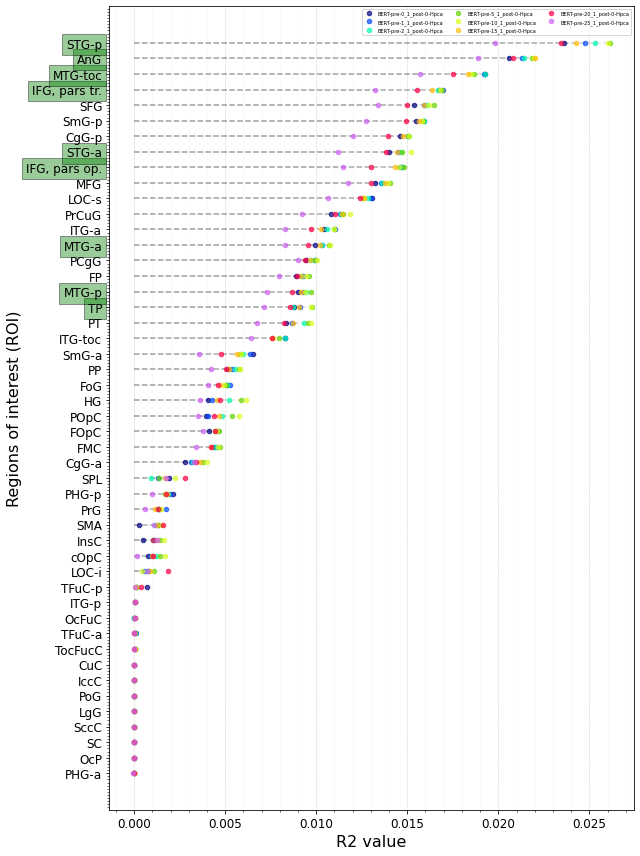

In [70]:
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:19<00:00,  2.47it/s]


		-->Done


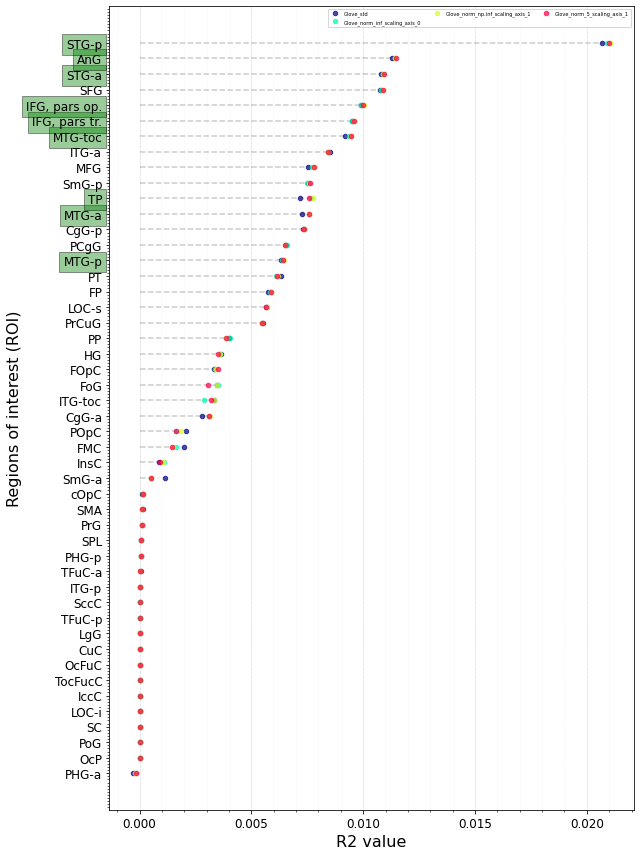

In [27]:
model_names = [
    'glove_300_standardize_centering_{}',
    'glove_300_norm_np.inf_centering_scaling_axis_0_{}',
    'glove_300_norm_np.inf_centering_{}',
    'glove_300_norm_5_centering_scaling_axis_1_{}',
    #'glove_300_norm_4_centering_scaling_axis_1_{}',
    #'glove_300_norm_3_centering_scaling_axis_1_{}',
    #'glove_300_norm_2_centering_{}',
]
legend_names = [
    'Glove_std',
    'Glove_norm_inf_scaling_axis_0',
    'Glove_norm_np.inf_scaling_axis_1',
    'Glove_norm_5_scaling_axis_1',
    #'Glove_norm_4_scaling_axis_1',
    #'Glove_norm_3_scaling_axis_1',
    #'Glove_norm_2_scaling_axis_1',
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


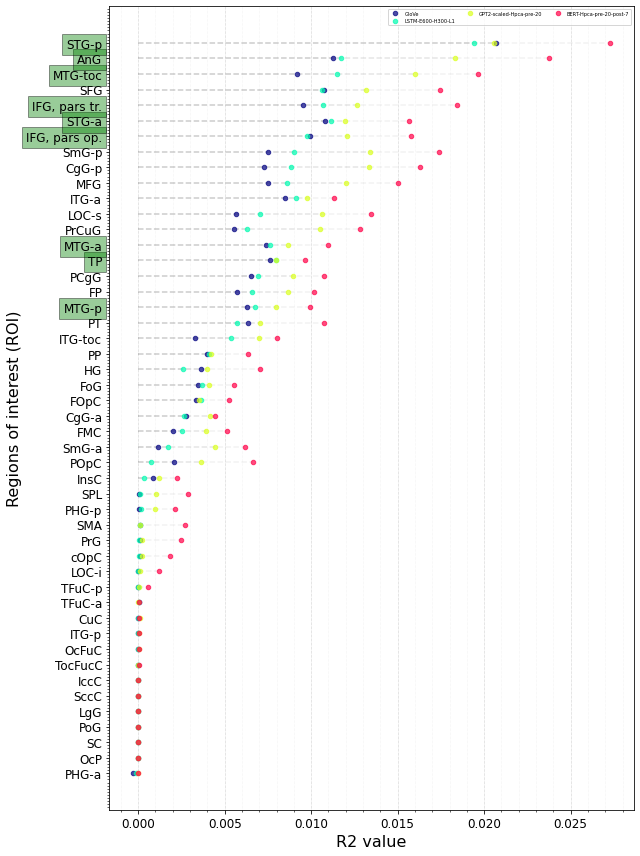

In [34]:
model_names = [
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300'
]
legend_names = ['GloVe', 
                'LSTM-E600-H300-L1', 
                'GPT2-scaled-Hpca-pre-20', 
                'BERT-Hpca-pre-20-post-7'
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

In [55]:
def horizontal_plot(
    data, 
    legend_names, 
    analysis_name, 
    save_folder, 
    label_names,
    figsize=(9,20), 
    title=None, 
    ylabel='Regions of interest (ROI)', 
    xlabel='R2 value', 
    model_name=''
    ):
    """Plots models horizontally.
    """

    limit = None
    dash_inf = limit[0] if limit is not None else 0
    plt.figure(figsize=figsize) # (7.6,12)
    ax = plt.axes()
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, data.shape[0] + 1)]
    for col in range(data.shape[0]):
        plt.plot(legend_names, data[col, :], '.-', alpha=0.7, markersize=9, color=colors[col])
    plt.title(title)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)

    plt.xlim(limit)
    plt.minorticks_on()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
    plt.legend(label_names, ncol=3, bbox_to_anchor=(0,0,1,1), fontsize=10)

    plt.tight_layout()
    check_folder(save_folder)
    if save_folder:
        plt.savefig(os.path.join(save_folder, '{model_name}-{analysis_name}.png'.format(model_name=model_name,
                                                                                        analysis_name=analysis_name)))
        plt.close('all')
    else:
        plt.show()

In [41]:
model_names = [
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300'
]
legend_names = ['GloVe', 
                'LSTM-E600-H300-L1', 
                'GPT2-scaled-Hpca-pre-20', 
                'BERT-Hpca-pre-20-post-7'
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]

		-->Done


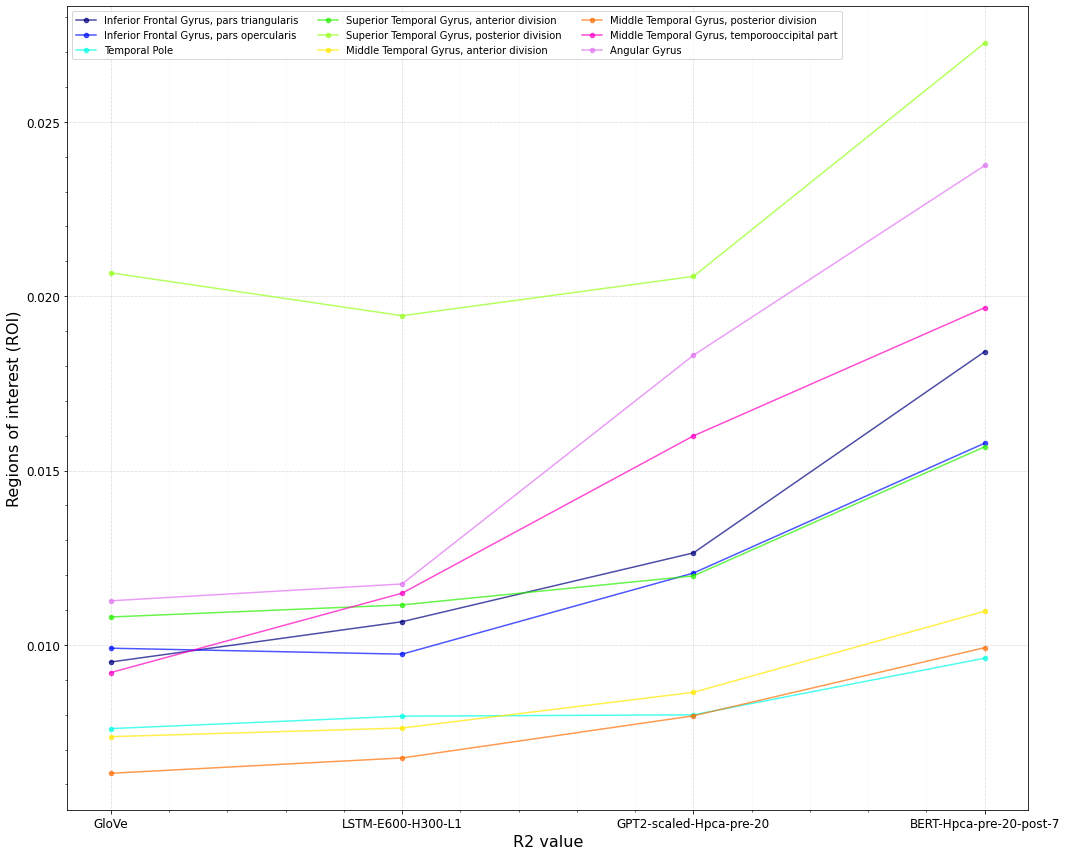

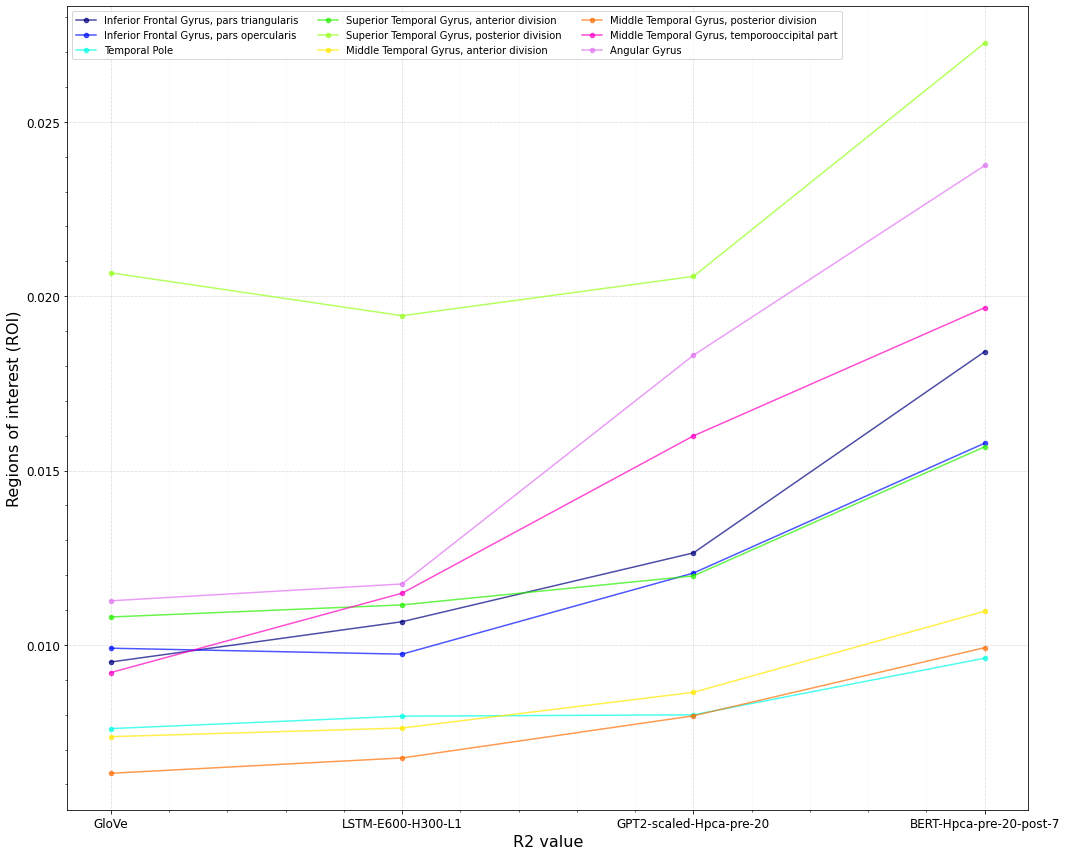

In [56]:
def clever_plot(data, x_labels, model_names):
    syntactic_data = []
    language_data = []
    legends = []
    for name in load_syntactic_roi():
        if name in x_labels:
            syntactic_data.append(data[x_labels.index(name), :])
            legends.append(name)
    syntactic_data = np.vstack(syntactic_data)
    horizontal_plot(
        syntactic_data, 
        model_names, 
        analysis_name='Third_Quartile_R2_per_syntactic_ROI', 
        save_folder=None, 
        label_names=legends,
        figsize=(15,12), 
        title=None, 
        ylabel='Regions of interest (ROI)', 
        xlabel='R2 value', 
        model_name='Model_comparison'
        )
    legends = []
    for name in load_language_roi():
        if name in x_labels:
            language_data.append(data[x_labels.index(name), :])
            legends.append(name)
    language_data = np.vstack(language_data)
    horizontal_plot(
        language_data, 
        model_names, 
        analysis_name='Third_Quartile_R2_per_language_ROI', 
        save_folder=None, 
        label_names=legends,
        figsize=(15,12), 
        title=None, 
        ylabel='Regions of interest (ROI)', 
        xlabel='R2 value', 
        model_name='Model_comparison'
        )
    
clever_plot(third_quartile, x_labels, legend_names)

#horizontal_plot(
#    third_quartile, 
#    legend_names, 
#    analysis_name='Third_Quartile_R2_per_ROI', 
#    save_folder=None, 
#    label_names=x_labels,
#    figsize=(15,12), 
#    title=None, 
#    ylabel='Regions of interest (ROI)', 
#    xlabel='R2 value', 
#    model_name='Model_comparison'
#    )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


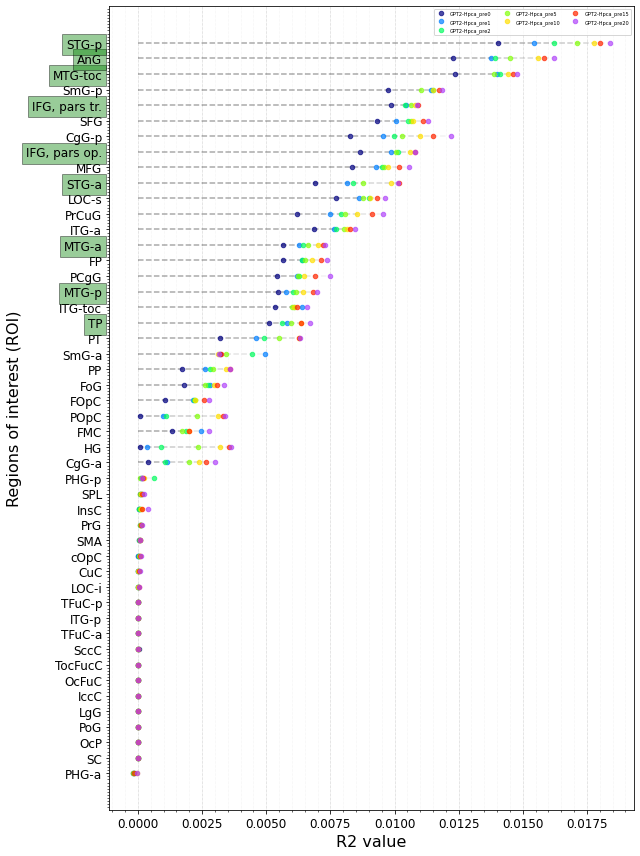

In [25]:
model_names = ['gpt2_pre-0_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-2_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['GPT2-Hpca_pre0',
                'GPT2-Hpca_pre1', 
                'GPT2-Hpca_pre2', 
                'GPT2-Hpca_pre5', 
                'GPT2-Hpca_pre10', 
                'GPT2-Hpca_pre15',
                'GPT2-Hpca_pre20'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


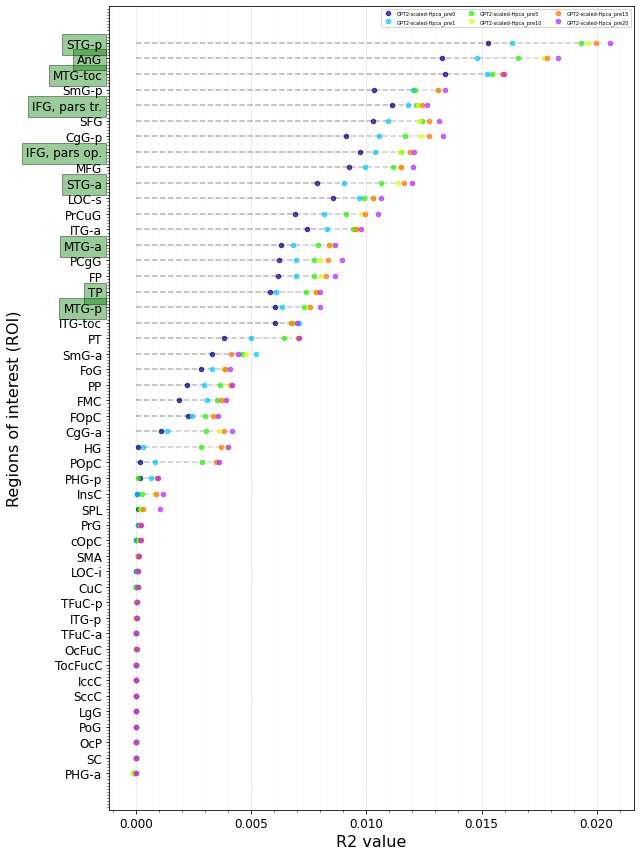

In [26]:
model_names = [
    'gpt2_pre-0_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['GPT2-scaled-Hpca_pre0',
                'GPT2-scaled-Hpca_pre1', 
                'GPT2-scaled-Hpca_pre5', 
                'GPT2-scaled-Hpca_pre10', 
                'GPT2-scaled-Hpca_pre15',
                'GPT2-scaled-Hpca_pre20'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:26<00:00,  1.81it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


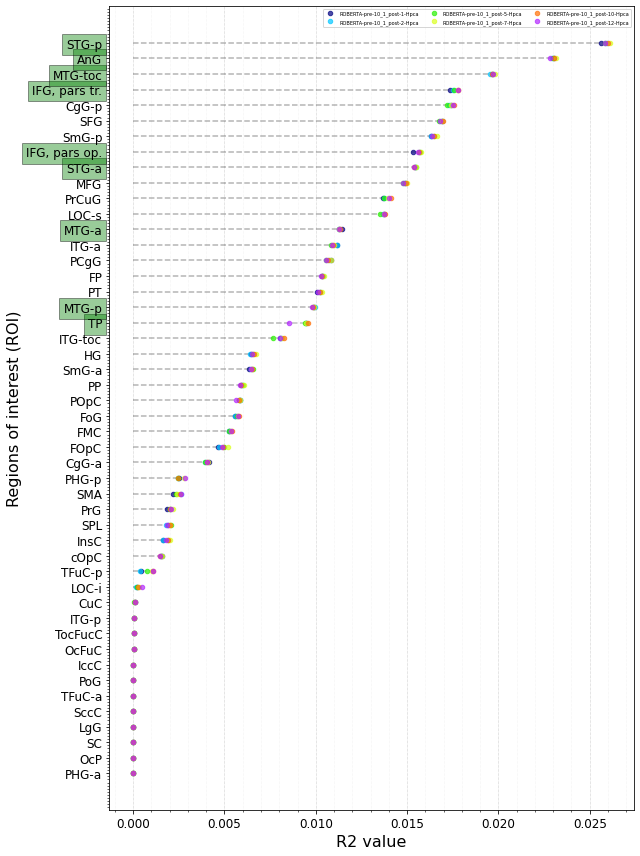

In [15]:
model_names = [
    'roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
              ]
legend_names = ['ROBERTA-pre-10_1_post-1-Hpca',
                'ROBERTA-pre-10_1_post-2-Hpca',
                'ROBERTA-pre-10_1_post-5-Hpca',
                'ROBERTA-pre-10_1_post-7-Hpca',
                'ROBERTA-pre-10_1_post-10-Hpca',
                'ROBERTA-pre-10_1_post-12-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


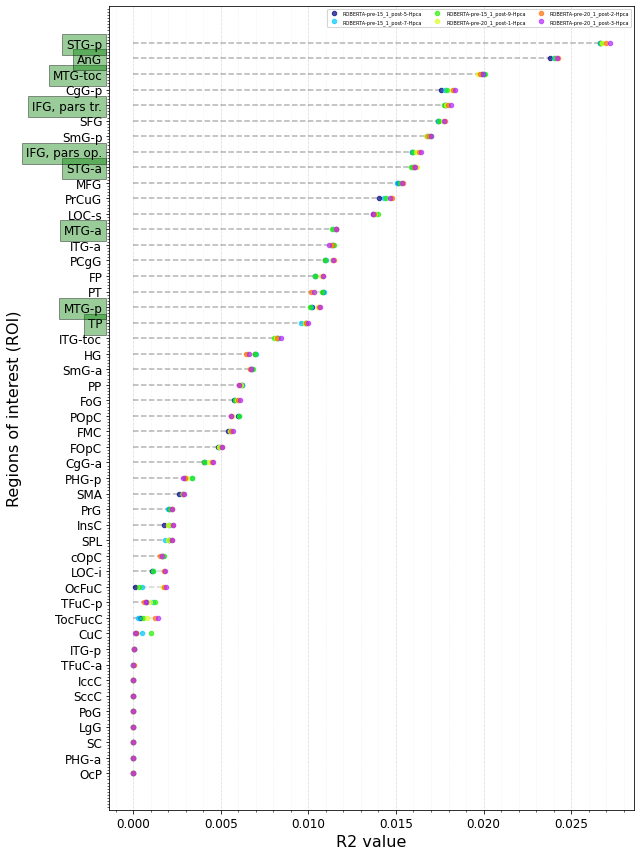

In [16]:
model_names = [
    'roberta-base_pre-15_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-9_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-3_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['ROBERTA-pre-15_1_post-5-Hpca',
                'ROBERTA-pre-15_1_post-7-Hpca',
                'ROBERTA-pre-15_1_post-9-Hpca',
                'ROBERTA-pre-20_1_post-1-Hpca',
                'ROBERTA-pre-20_1_post-2-Hpca',
                'ROBERTA-pre-20_1_post-3-Hpca'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


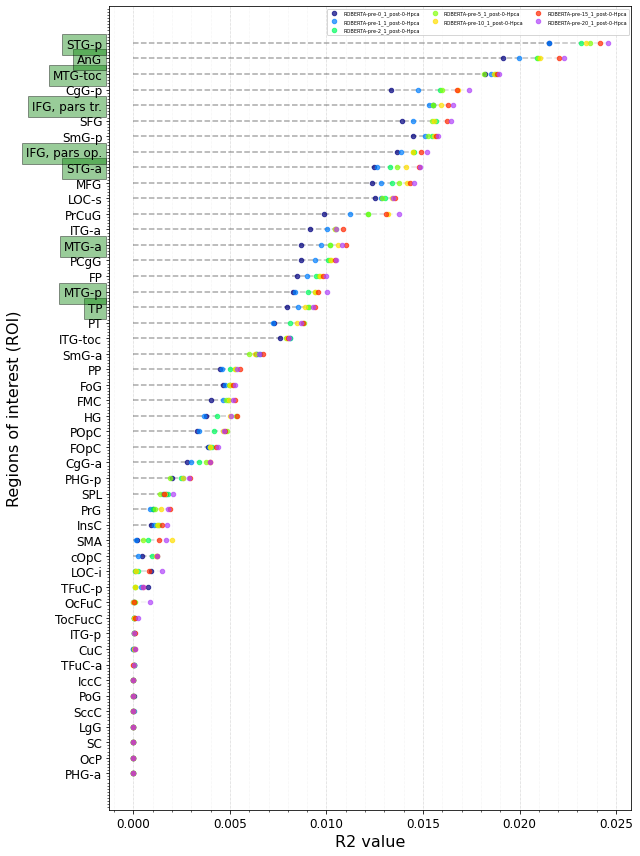

In [17]:
model_names = [
    'roberta-base_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-0_{}_all-hidden-layers_pca_300'    
              ]
legend_names = ['ROBERTA-pre-0_1_post-0-Hpca',
                'ROBERTA-pre-1_1_post-0-Hpca',
                'ROBERTA-pre-2_1_post-0-Hpca',
                'ROBERTA-pre-5_1_post-0-Hpca',
                'ROBERTA-pre-10_1_post-0-Hpca',
                'ROBERTA-pre-15_1_post-0-Hpca',
                'ROBERTA-pre-20_1_post-0-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


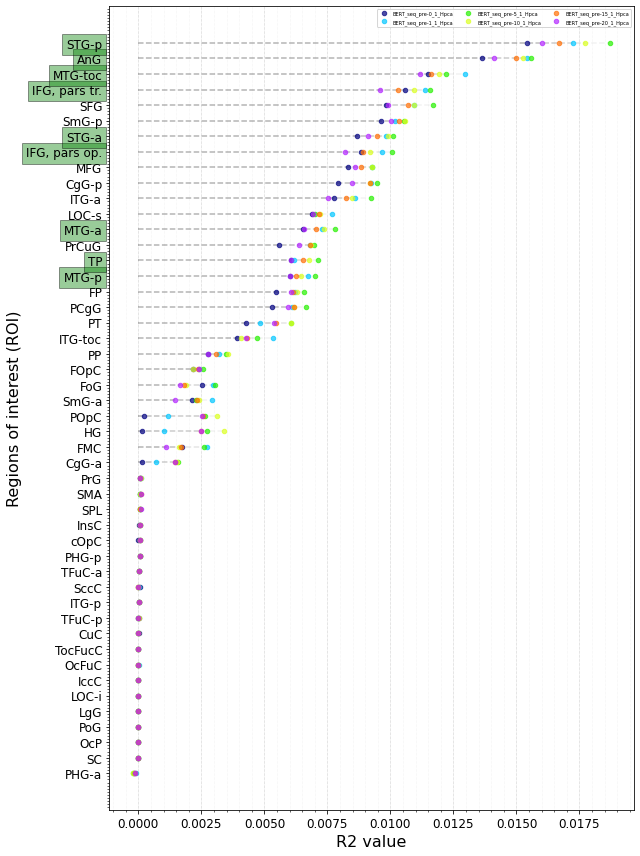

In [63]:
model_names = [
    'bert-base-cased_seq_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-20_1_post-0_{}_all-hidden-layers_pca_300'    
              ]
legend_names = ['BERT_seq_pre-0_1_Hpca',
                'BERT_seq_pre-1_1_Hpca',
                'BERT_seq_pre-5_1_Hpca',
                'BERT_seq_pre-10_1_Hpca',
                'BERT_seq_pre-15_1_Hpca',
                'BERT_seq_pre-20_1_Hpca',
                ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


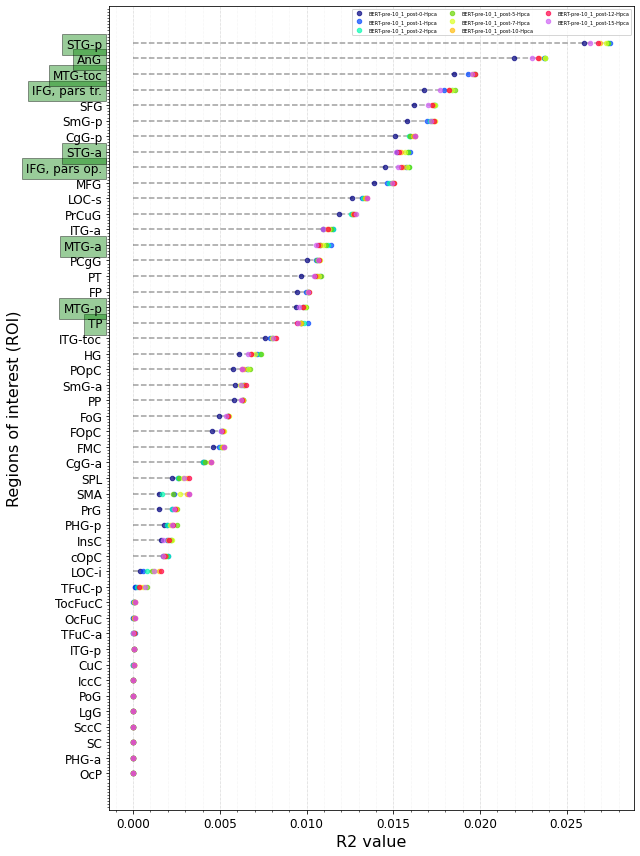

In [64]:
model_names = [
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
              ]
legend_names = ['BERT-pre-10_1_post-0-Hpca',
                'BERT-pre-10_1_post-1-Hpca',
                'BERT-pre-10_1_post-2-Hpca',
                'BERT-pre-10_1_post-5-Hpca',
                'BERT-pre-10_1_post-7-Hpca',
                'BERT-pre-10_1_post-10-Hpca',
                'BERT-pre-10_1_post-12-Hpca',
                'BERT-pre-10_1_post-15-Hpca',
                
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:38<00:00,  1.24it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


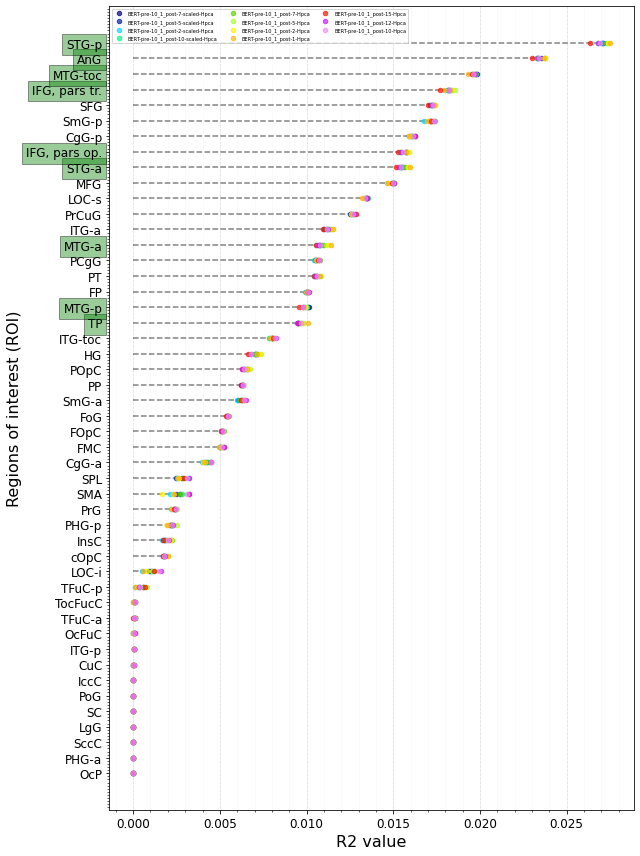

In [31]:
model_names = [
    'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300', #'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
              ]

legend_names = [
                'BERT-pre-10_1_post-7-scaled-Hpca',
                'BERT-pre-10_1_post-5-scaled-Hpca',
                'BERT-pre-10_1_post-2-scaled-Hpca',
                'BERT-pre-10_1_post-10-scaled-Hpca', #'BERT-pre-10_1_post-0-scaled-Hpca',
                'BERT-pre-10_1_post-7-Hpca',
                'BERT-pre-10_1_post-5-Hpca',
                'BERT-pre-10_1_post-2-Hpca',
                'BERT-pre-10_1_post-1-Hpca',
                'BERT-pre-10_1_post-15-Hpca',
                'BERT-pre-10_1_post-12-Hpca',
                'BERT-pre-10_1_post-10-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

In [25]:
df = pd.DataFrame(third_quartile.T, columns=x_labels)
df.index = pd.Index(legend_names)
df

,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Operculum Cortex,Central Opercular Cortex,Parietal Operculum Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
BERT-pre-10_1_post-7-scaled-Hpca,0.010043,0.001862,0.017240,0.015060,0.018133,0.015761,0.002404,0.009532,0.015454,0.027030,...,0.000074,0.000036,0.005152,0.001725,0.006421,0.006248,0.007006,0.010538,2.304150e-06,3.500453e-15
BERT-pre-10_1_post-5-scaled-Hpca,0.009974,0.001799,0.017142,0.014917,0.018264,0.015714,0.002341,0.009527,0.015502,0.027099,...,0.000032,0.000016,0.005098,0.001771,0.006548,0.006346,0.007117,0.010597,1.822325e-06,4.933668e-13
BERT-pre-10_1_post-2-scaled-Hpca,0.009884,0.001677,0.017183,0.014725,0.018160,0.015451,0.002172,0.009769,0.015611,0.027041,...,0.000009,0.000011,0.005067,0.001851,0.006428,0.006325,0.007092,0.010456,1.883847e-06,3.464977e-15
BERT-pre-10_1_post-10-scaled-Hpca,0.010013,0.001884,0.017258,0.015058,0.018078,0.015413,0.002400,0.009530,0.015380,0.026841,...,0.000079,0.000059,0.005211,0.001718,0.006393,0.006301,0.007014,0.010460,2.499193e-06,3.649101e-15
BERT-pre-10_1_post-7-Hpca,0.010136,0.002028,0.017386,0.014995,0.018354,0.015717,0.002379,0.009420,0.015488,0.027175,...,0.000090,0.000036,0.005167,0.001881,0.006586,0.006345,0.006957,0.010648,2.335397e-06,3.330325e-14
BERT-pre-10_1_post-5-Hpca,0.010099,0.002212,0.017380,0.014914,0.018523,0.015811,0.002502,0.009716,0.015736,0.027223,...,0.000048,0.000052,0.005180,0.001920,0.006774,0.006397,0.007249,0.010815,1.968376e-06,3.240656e-14
BERT-pre-10_1_post-2-Hpca,0.010043,0.002088,0.017433,0.014760,0.018398,0.015769,0.002240,0.009852,0.015929,0.027476,...,0.000023,0.000009,0.005135,0.001998,0.006603,0.006365,0.007342,0.010582,1.936587e-06,2.968144e-14
BERT-pre-10_1_post-1-Hpca,0.010047,0.001920,0.017436,0.014632,0.017986,0.015552,0.002209,0.010131,0.015968,0.027479,...,0.000015,0.000010,0.005073,0.001968,0.006658,0.006376,0.007215,0.010709,1.750690e-07,5.545343e-13
BERT-pre-10_1_post-15-Hpca,0.010058,0.001768,0.016916,0.014803,0.017806,0.015382,0.002403,0.009334,0.014991,0.026291,...,0.000088,0.000103,0.005122,0.001764,0.006303,0.006190,0.006702,0.010464,2.688484e-06,4.014184e-14
BERT-pre-10_1_post-12-Hpca,0.010107,0.002249,0.017276,0.015040,0.018103,0.015548,0.002454,0.009659,0.015294,0.026838,...,0.000099,0.000060,0.005140,0.001803,0.006300,0.006287,0.006790,0.010464,2.533544e-06,3.466606e-13


In [19]:
comparisons = {
    'BERT_pre-10_1_post-0_vs_scaled' : ['bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-2_vs_scaled' : ['bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-5_vs_scaled' : ['bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-7_vs_scaled' : ['bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-10_vs_scaled' : ['bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300'],
}
comparisons = {
    'ROBERTA_pre-10_1_post-1_vs_BERT' : ['roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-2_vs_BERT' : ['roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-5_vs_BERT' : ['roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-12_vs_BERT' : ['roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-10_vs_BERT' : ['roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300'],
}


for comparison in comparisons:
    imgs_1 = data_full[comparisons[comparison][0].replace('_{}', '')]['R2']
    imgs_2 = data_full[comparisons[comparison][1].replace('_{}', '')]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
paths = {}
data_model_comparison = {}
for comparison in comparisons:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    data_model_comparison[name] = []
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

#####  ROBERTA_pre-10_1_post-1-vs-BERT__R2  #####


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


#####  ROBERTA_pre-10_1_post-2-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-5-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-12-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-10-vs-BERT__R2  #####


  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


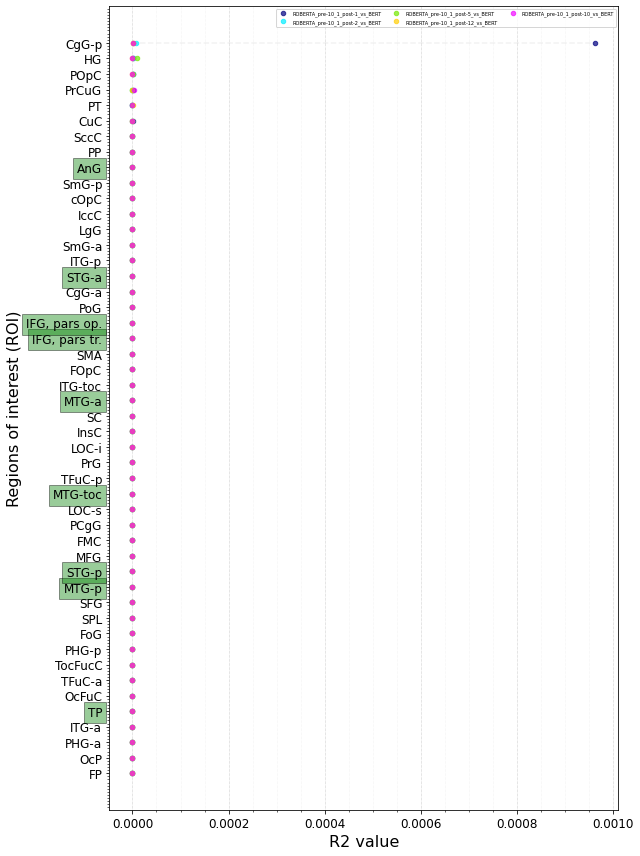

In [20]:
model_names = [
    'BERT_pre-10_1_post-0_vs_scaled',
    'BERT_pre-10_1_post-2_vs_scaled',
    'BERT_pre-10_1_post-5_vs_scaled',
    'BERT_pre-10_1_post-7_vs_scaled',
    'BERT_pre-10_1_post-10_vs_scaled'
              ]
model_names = ['ROBERTA_pre-10_1_post-1_vs_BERT' ,
    'ROBERTA_pre-10_1_post-2_vs_BERT',
    'ROBERTA_pre-10_1_post-5_vs_BERT',
    'ROBERTA_pre-10_1_post-12_vs_BERT',
    'ROBERTA_pre-10_1_post-10_vs_BERT']

legend_names = [
    'BERT_pre-10_1_post-0_vs_scaled',
    'BERT_pre-10_1_post-2_vs_scaled',
    'BERT_pre-10_1_post-5_vs_scaled',
    'BERT_pre-10_1_post-7_vs_scaled',
    'BERT_pre-10_1_post-10_vs_scaled'
               ]
legend_names = ['ROBERTA_pre-10_1_post-1_vs_BERT' ,
    'ROBERTA_pre-10_1_post-2_vs_BERT',
    'ROBERTA_pre-10_1_post-5_vs_BERT',
    'ROBERTA_pre-10_1_post-12_vs_BERT',
    'ROBERTA_pre-10_1_post-10_vs_BERT']


data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

########## ROBERTA_pre-10_1_post-1_vs_BERT ##########


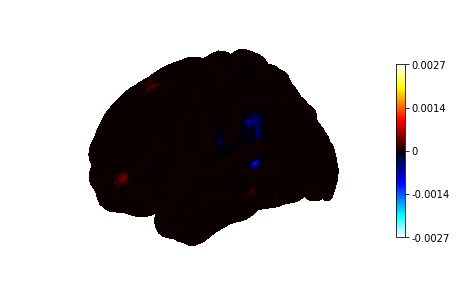

########## ROBERTA_pre-10_1_post-2_vs_BERT ##########


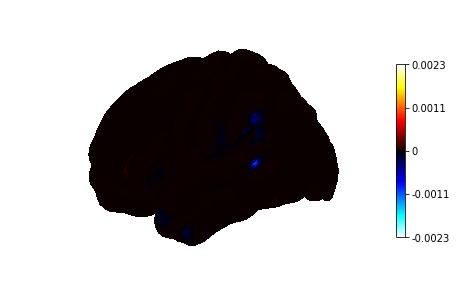

########## ROBERTA_pre-10_1_post-5_vs_BERT ##########


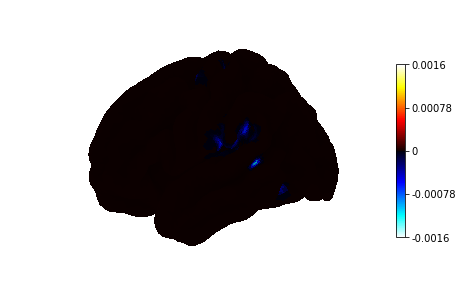

########## ROBERTA_pre-10_1_post-12_vs_BERT ##########


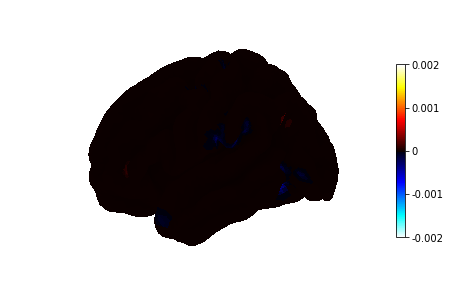

########## ROBERTA_pre-10_1_post-10_vs_BERT ##########


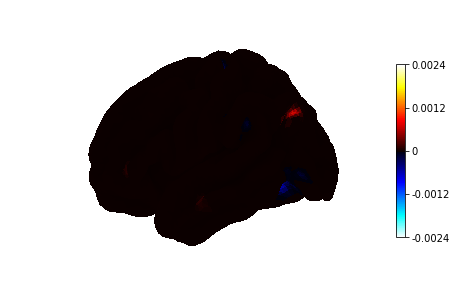

In [23]:
for index_comp, comparison in enumerate(comparisons):
    saving_path = os.path.dirname(paths[comparison])
    print("#"*10, comparison, "#"*10)
    reporting.plot_img_surf(paths[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.01, **kwargs)

### Surface plots

#### Surface plots showing which model predicts better (voxel-wise)

In [49]:
model_names = [
    'glove_300',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers',
    'gpt2_scaled_all-hidden-layers_pca_300',
    'bert-base-cased_old_all-hidden-layers_pca_300'
]

In [22]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}

In [51]:
img = reporting.get_voxel_wise_max_img_on_surf(
                            masker, 
                            model_names, 
                            language='english', 
                            PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/',
                            **kwargs
                            )

In [52]:
# saving_path = 

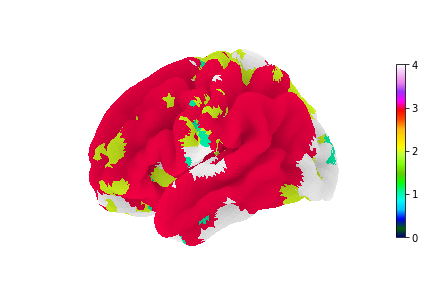

In [53]:
reporting.plot_roi_img_surf(img, saving_path=None, plot_name='model_comparison_surf', inflated=False, compute_surf=False, **kwargs)

In [23]:
view = reporting.interactive_surf_plot(img, inflated=False, **kwargs)
view

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
2

#### Surface plots of group-level difference analysis maps

In [54]:
comparisons = {
    'LSTM_300-H_vs_Glove' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'glove_300'],
    'BERT-Hpca_vs_GPT2-scaled-Hpca' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'gpt2_scaled_all-hidden-layers_pca_300'],
    'BERT-Hpca_vs_LSTM_300-H' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
    'GPT2-scaled-Hpca_vs_LSTM_300-H' : ['gpt2_scaled_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
    'BERT-Hpca_vs_Glove' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'glove_300'],
    'GPT2-scaled-Hpca_vs_Glove' : ['gpt2_scaled_all-hidden-layers_pca_300', 'glove_300']   
}

In [43]:
for comparison in comparisons:
    imgs_1 = data_full[comparisons[comparison][0]]['R2']
    imgs_2 = data_full[comparisons[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )

#####  LSTM_300-H-vs-Glove__R2  #####
#####  BERT-Hpca-vs-GPT2-scaled-Hpca__R2  #####
#####  BERT-Hpca-vs-LSTM_300-H__R2  #####
#####  GPT2-scaled-Hpca-vs-LSTM_300-H__R2  #####
#####  BERT-Hpca-vs-Glove__R2  #####
#####  GPT2-scaled-Hpca-vs-Glove__R2  #####


In [55]:
paths = {}
for comparison in comparisons:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

In [39]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.05
}

########## LSTM_300-H_vs_Glove ##########


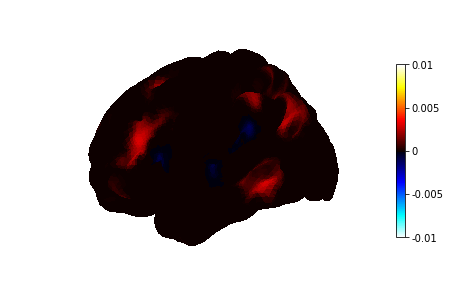

########## BERT-Hpca_vs_GPT2-scaled-Hpca ##########


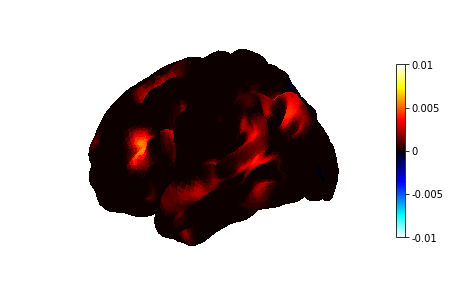

########## BERT-Hpca_vs_LSTM_300-H ##########


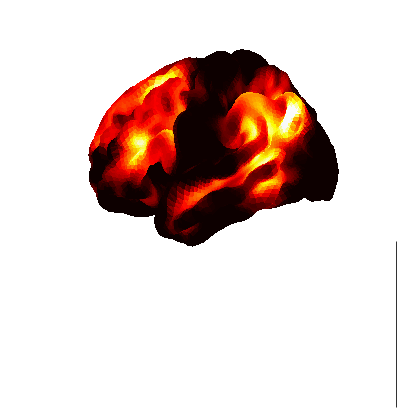

########## GPT2-scaled-Hpca_vs_LSTM_300-H ##########


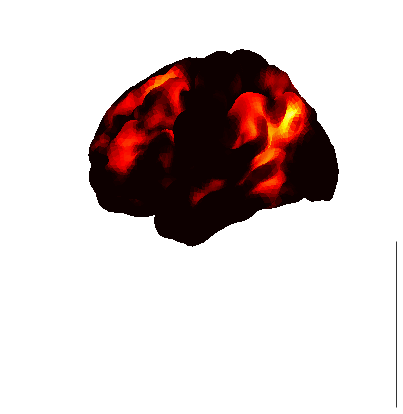

########## BERT-Hpca_vs_Glove ##########


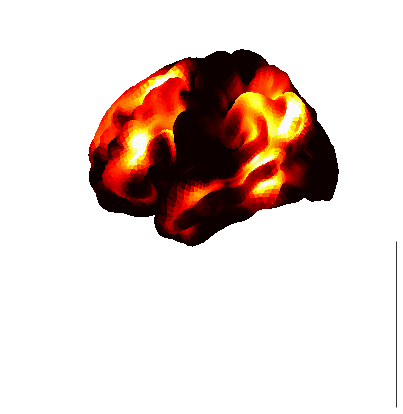

########## GPT2-scaled-Hpca_vs_Glove ##########


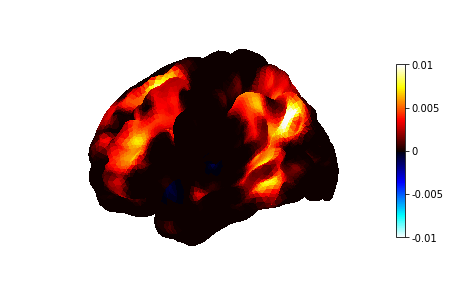

In [58]:
for index_comp, comparison in enumerate(comparisons):
    saving_path = os.path.dirname(paths[comparison])
    print("#"*10, comparison, "#"*10)
    plot_img_surf(paths[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.01, **kwargs)

## LSTM gates analysis

In [59]:
lstm_names = [
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-out-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-in-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-forget-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-c_tilde-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-cell-layers'
]

lstm_legends = ['LSTM-E600-O300-L1', 
                'LSTM-E600-I300-L1', 
                'LSTM-E600-H300-L1',
                'LSTM-E600-F300-L1',
                'LSTM-E600-CT300-L1',
                'LSTM-E600-C300-L1'
               ]

Retrieving data and computing group level analysis:

In [60]:
data_lstm_gates = reporting.get_model_data(lstm_names, language, OUTPUT_PATH)
reporting.check_data(data_full, 51)
reporting.compute_t_test_for_model_comparison(
                                        data_lstm_gates, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

  4%|▍         | 2/51 [00:00<00:05,  8.46it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.05it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.14it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.64it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.79it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  7.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.37it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03,  8.78it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.10it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.80it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  8.84it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 11.11it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 11.08it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.90it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  7.96it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 10.01it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 11.33it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.88it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 12.49it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


100%|██████████| 51/51 [00:05<00:00,  9.52it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1



  4%|▍         | 2/51 [00:00<00:03, 16.27it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.30it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.71it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.91it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.12it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.60it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.71it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.03it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 12.90it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.47it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.10it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 12.33it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 11.69it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 11.17it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:01, 10.81it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00,  9.25it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  8.88it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 10.52it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.94it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.16it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 12.27it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.86it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 14.65it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 14.44it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.65it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 16.22it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 13.29it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 12.46it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 14.25it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.19it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.37it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.26it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 12.39it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 18.75it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 15.12it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.12it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 13.84it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 15.04it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.53it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.78it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 13.92it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 12.56it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 14.46it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.57it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 15.28it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 12.93it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.48it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 14.08it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 12.65it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:11,  4.31it/s]

sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:11,  4.10it/s]

sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:12,  3.91it/s]

sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:11,  3.80it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.26it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:03,  9.32it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:02, 12.05it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.72it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 14.26it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 16.05it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 14.86it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 13.68it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 14.16it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.97it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.28it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  6.06it/s]

sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  5.41it/s]

sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  4.60it/s]

sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  4.05it/s]

sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  4.06it/s]

sub-113 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  4.03it/s]

sub-114 - 1 - 1


100%|██████████| 51/51 [00:06<00:00,  8.11it/s]

sub-115 - 1 - 1
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers_R2  #####


#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-c_tilde-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_eng

In [37]:
data_lstm_vertical = reporting.get_data_per_roi(
                                data_lstm_gates, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean_lstm = data_lstm_vertical['mean']
third_quartile_lstm = data_lstm_vertical['third_quartile']

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:31<00:00,  1.53it/s]

		-->Done


/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


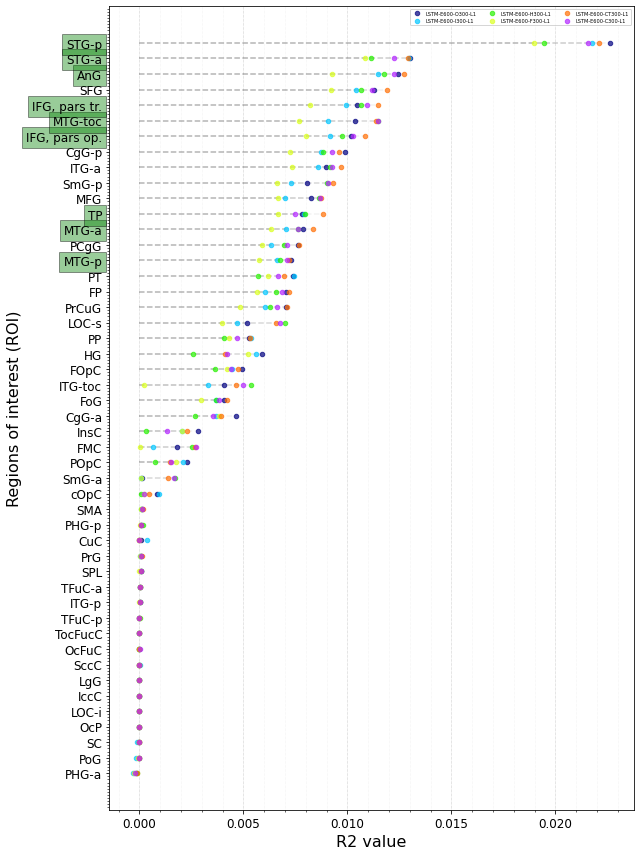

In [40]:
reporting.vertical_plot(
                third_quartile_lstm, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=lstm_legends, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='LSTM gates comparison'
                )

In [65]:
comparisons_lstm = {
    'LSTM-E600-I300-L1_vs_LSTM-E600-F300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-O300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-I300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-F300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-C300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-cell-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-CT300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-c_tilde-layers']
}
for comparison in comparisons_lstm:
    imgs_1 = data_lstm_gates[comparisons_lstm[comparison][0]]['R2']
    imgs_2 = data_lstm_gates[comparisons_lstm[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )

#####  LSTM-E600-I300-L1-vs-LSTM-E600-F300-L1__R2  #####
#####  LSTM-E600-H300-L1-vs-LSTM-E600-O300-L1__R2  #####
#####  LSTM-E600-H300-L1-vs-LSTM-E600-I300-L1__R2  #####


KeyboardInterrupt: 

In [66]:
paths_lstm = {}
for comparison in comparisons_lstm:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_lstm[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

########## LSTM-E600-I300-L1_vs_LSTM-E600-F300-L1 ##########


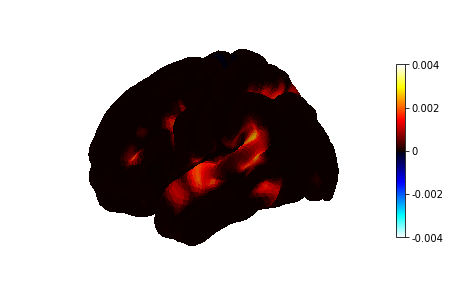

########## LSTM-E600-H300-L1_vs_LSTM-E600-O300-L1 ##########


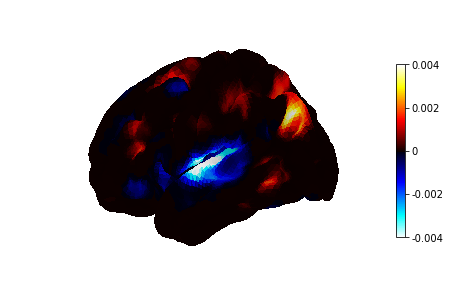

########## LSTM-E600-H300-L1_vs_LSTM-E600-I300-L1 ##########


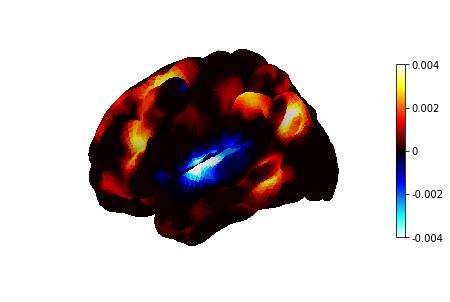

########## LSTM-E600-H300-L1_vs_LSTM-E600-F300-L1 ##########


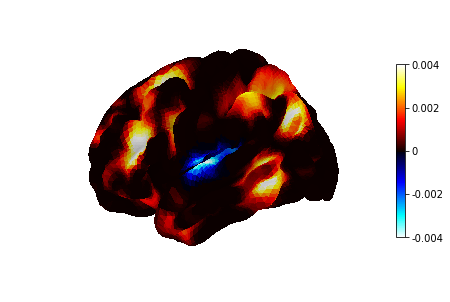

########## LSTM-E600-H300-L1_vs_LSTM-E600-C300-L1 ##########


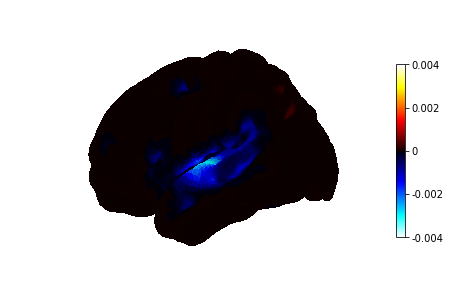

########## LSTM-E600-H300-L1_vs_LSTM-E600-CT300-L1 ##########


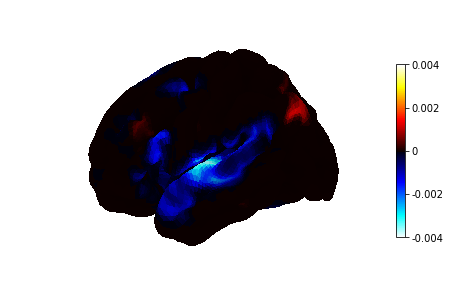

In [69]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}
for index_comp, comparison in enumerate(comparisons_lstm):
    saving_path = os.path.dirname(paths_lstm[comparison])
    print("#"*10, comparison, "#"*10)
    plot_img_surf(paths_lstm[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.004, **kwargs)

## BERT vs GPT2

#### Comparison of Bert - Bert_seq - GPT2 with all hidden states of all layers

Here we compute group level maps for each model independently:

In [ ]:
big_model_names = [
    'gpt2_scaled_{}_all-hidden-layers',
    'bert-base-cased_{}_all-hidden-layers',
    'bert-base-cased_sequential_{}_all-hidden-layers'
]

big_model_legends = [
    'GPT2_scaled-H',
    'BERT-H',
    'Bert-seq-H'
]
data_big_models = reporting.get_model_data(big_model_names, language, OUTPUT_PATH)
reporting.check_data(data_big_models, 51)
reporting.compute_t_test_for_model_comparison(
                                        data_big_models, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

Here we compute group level maps of the difference between models:

In [ ]:
comparisons_big_models = {
    'BERT-H_vs_GPT2-scaled-H' : ['bert-base-cased_all-hidden-layers', 'gpt2_scaled_all-hidden-layers'],
    'BERT-H_vs_BERT-seq-H' : ['bert-base-cased_all-hidden-layers', 'bert-base-cased_sequential_all-hidden-layers'],
    'GPT2-scaled-H_vs_BERT-seq-H' : ['gpt2_scaled_all-hidden-layers', 'bert-base-cased_sequential_all-hidden-layers'],
}
for comparison in comparisons_big_models:
    imgs_1 = data_big_models[comparisons_big_models[comparison][0]]['R2']
    imgs_2 = data_big_models[comparisons_big_models[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
paths_big_models = {}
for comparison in comparisons_big_models:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_big_models[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

Surface plots:

In [ ]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}
for index_comp, comparison in enumerate(comparisons_big_models):
    saving_path = os.path.dirname(paths_big_models[index_comp])
    plot_img_surf(paths_big_models[index_comp], saving_path=None, plot_name=comparison+'_surf', inflated=False, **kwargs):
        

#### Respective layer-wise analysis

In [ ]:
layer_analysis_model_names = [
    'gpt2_scaled',
    'bert-base-cased',
    'bert-base-cased_sequential'
]

In [ ]:
data_layers = get_layers_data(
                        layer_analysis_model_names, 
                        analysis=reporting.get_default_analysis(), 
                        language='english',
                        OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/'
                        )

In [ ]:
for model_name in data_layers.keys():
    data_tmp_vertical = reporting.get_data_per_roi(
                                    data_layers, 
                                    atlas_maps,
                                    labels,
                                    analysis=reporting.get_default_analysis(),
                                    model_name=model_name,
                                    language='english', 
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
    mean_big_models = data_tmp_vertical['mean']
    third_quartile_big_models = data_tmp_vertical['third_quartile']
    reporting.vertical_plot(
                    third_quartile_big_models, 
                    x_labels, 
                    'Third_Quartile_R2_per_ROI',
                    save_folder=None, 
                    'R2', 
                    reporting.load_surnames(),
                    big_model_legends, 
                    reporting.load_syntactic_roi(), 
                    reporting.load_language_roi(), 
                    figsize=(9,12), 
                    count=False, 
                    title=None, 
                    ylabel='Regions of interest (ROI)', 
                    xlabel='R2 value', 
                    model_name='Model_comparison'
                    )

#### ROI surface plots 

The following surface plots indicate which layer predicts best which voxel.

In [ ]:
for model_name in data_layers.keys():
    for key in analysis:
        if key != 'Specific-attention-heads':
            maps = []
            for model in data[model_name][key].keys():
                if model == 'models':
                    models = data[model_name][key][model]
                else:
                    name = '_'.join([model_name, model])
                    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                    name = 'R2_group_fdr_effect'
                    maps.append(fetch_map(path, name)[0])
            # Small reordering of models so that layers are in increasing order
            if key=='Hidden-layers':
                maps = maps[:2] + maps[5:] + maps[2:5]
                models = models[:2] + models[5:] + models[2:5]
                load = 0
            elif key=='Attention-layers':
                maps = maps[:1] + maps[4:] + maps[1:4]
                models = models[:1] + models[4:] + models[1:4]
                load = 1
            data_tmp = np.stack(masker.transform(map_) for map_ in maps)
            data_tmp = np.argmax(data_tmp, axis=0)
            data_tmp = (data_tmp + load)

            plot_name = "R2-{}-{}".format(model_name, key)

            img = masker.inverse_transform(data_tmp)

            saving_path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/glass_brains/'.format(language))
            check_folder(saving_path)
            print(plot_name)
            
            kwargs = {
                'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
                'surf_mesh_type': 'pial_left',
                'hemi':'left', # right
                'view':'lateral', # medial
                'bg_map': 'sulc_left', # sulc_right
                'bg_on_data':True,
                'darkness':.5
            }
            
            reporting.plot_roi_img_surf(img, saving_path=None, plot_name=model_name+'_surf', inflated=False, **kwargs)


#### Layer-wise analysis comparison (vertical plot)

In [ ]:
for model_name in data_layers.keys():
    data_tmp_vertical = reporting.get_data_per_roi(
                                    data_layers, 
                                    atlas_maps,
                                    labels,
                                    analysis=reporting.get_default_analysis(),
                                    model_name=model_name,
                                    language='english', 
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
    mean_big_models = data_tmp_vertical['mean']
    third_quartile_big_models = data_tmp_vertical['third_quartile']
    reporting.vertical_plot(
                    third_quartile_big_models, 
                    x_labels, 
                    'Third_Quartile_R2_per_ROI',
                    save_folder=None, 
                    'R2', 
                    reporting.load_surnames(),
                    big_model_legends, 
                    reporting.load_syntactic_roi(), 
                    reporting.load_language_roi(), 
                    figsize=(9,12), 
                    count=False, 
                    title=None, 
                    ylabel='Regions of interest (ROI)', 
                    xlabel='R2 value', 
                    model_name='Model_comparison'
                    )